Frankenstein model:
Use two different types of unembedding within the ReLU(x) + x model: 
- Residual path
- MLP

Test different combinations of identity, transpose, pseudoinverse. 

In [1]:
# Set up notebook

"""Import necessary packages"""

%load_ext autoreload
%autoreload 2

import os
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
import seaborn as sns
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.plot import plot_loss_across_sparsities, plot_input_output_response, plot_phase_diagram_polysem
from toy_cis.plot import plot_weight_bars, plot_phase_diagram, plot_phase_diagram_training
from toy_cis.util import threshold_matrix, in_out_response, performance_across_sparsities

"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 16})

"""Set torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device = t.device("cpu")  # small toy models have lower loss and are faster via cpu
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA A40'


# Define and train Frankenstein model (different unembedding matrices for each output path)

In [ ]:
"""Frankenstein mode: ReLU + x model in which different unembedding matrices are used for the MLP output
and the residual: transpose vs pseudoinverse of the embedding matrix. 
"""

from dataclasses import dataclass, field
from typing import Callable, List
from tqdm.notebook import tqdm

import numpy as np
import torch as t

from einops import einsum, rearrange, reduce
from jaxtyping import Float
from torch import nn
from torch.nn import functional as F


@dataclass
class CisConfig:
    """Config class for single hidden layer CiS model."""
    name: str # name of the model
    n_instances: int  # number of model instances
    n_feat: int  # number of features (elements) in input vector
    n_hidden: int  # number of hidden units in the model
    act_fn: List[Callable] = field(default_factory=lambda: [F.relu, F.relu])  # layer act funcs
    # Bias terms for hidden and output layers. For a given layer, if None, biases are not learned;
    # if scalar, all biases have the same value; if tensor, each bias has the corresponding 
    # tensor element value.
    b1: float | Float[t.Tensor, "inst hid"] | None = None
    b2: float | Float[t.Tensor, "inst hid"] | None = 0.0
    W1_as_W2T: bool = False  # W2 is learned if False, else W2 = W1.T
    We_and_Wu: bool = False  # if True, use fixed, random orthogonal embed and unembed matrices
    We_dim: int = 1000  # if We_and_Wu, this is the dim of the embedding space
    skip_cnx: bool = False  # if True, skip connection from in to out is added
    


    def __post_init__(self):
        """Ensure attribute values are valid."""
        # Handle `b1` tensor validation
        if isinstance(self.b1, t.Tensor):
            expected_shape = (self.n_instances, self.n_hidden)
            if self.b1.shape != expected_shape:
                raise ValueError(f"{self.b1.shape=} does not match {expected_shape=}")
        
        # Handle `b2` tensor validation
        if isinstance(self.b2, t.Tensor):
            expected_shape = (self.n_instances, self.n_hidden)
            if self.b2.shape != expected_shape:
                raise ValueError(f"{self.b2.shape=} does not match {expected_shape=}")



class Cis(nn.Module):
    """A generic computation-in-superposition toy model."""
    # Some attribute type hints
    W1: Float[t.Tensor, "inst hid feat"]
    W2: Float[t.Tensor, "inst feat hid"]
    b1: Float[t.Tensor, "inst hid"]
    b2: Float[t.Tensor, "inst feat"]


    def __init__(self, cfg: CisConfig, device: t.device):
        """Initializes model params."""
        super().__init__()
        self.cfg = cfg
        self.device = device
        n_feat = cfg.n_feat

        # Embed and Unembed Matrices
        if cfg.We_and_Wu:
            rand_unit_mats = [
                F.normalize(t.randn(cfg.We_dim, cfg.n_feat), dim=0, p=2) for _ in range(cfg.n_instances)
            ]
            self.We = t.stack(rand_unit_mats).to(device)
            self.Wu_T = rearrange(self.We, "inst emb feat -> inst feat emb")
            self.Wu_p = t.linalg.pinv(self.We)
            n_feat = cfg.We_dim

        # Model Weights
        self.W1 = t.empty(cfg.n_instances, cfg.n_hidden, cfg.n_feat)
        self.W1 = nn.Parameter(nn.init.xavier_normal_(self.W1))
        if cfg.W1_as_W2T:
            self.W2 = self.W1.T
        else:
            self.W2 = t.empty(cfg.n_instances, cfg.n_feat, cfg.n_hidden)
            self.W2 = nn.Parameter(nn.init.xavier_normal_(self.W2))

        # Model Biases
        if cfg.b1 is None:
            self.b1 = t.zeros(cfg.n_instances, cfg.n_hidden, device=device)
        elif np.isscalar(cfg.b1):
            self.b1 = nn.Parameter(t.full((cfg.n_instances, cfg.n_hidden), cfg.b1))
        else:
            self.b1 = nn.Parameter(cfg.b1)

        if cfg.b2 is None:
            self.b2 = t.zeros(cfg.n_instances, cfg.n_feat, device=device)
        elif np.isscalar(cfg.b2):
            self.b2 = nn.Parameter(t.full((cfg.n_instances, cfg.n_feat), cfg.b2))
        else:
            self.b2 = nn.Parameter(cfg.b2)
        
        self.to(device)

    def forward(
        self, 
        x: Float[t.Tensor, "batch inst feat"],
        res_factor: float = 1.0,  # factor for skip connection
    ) -> Float[t.Tensor, "batch inst feat"]:
        """Runs a forward pass through the model."""
        # Embedding layer
        #if self.cfg.We_and_Wu:
            #x = einsum(x, self.We, "batch inst feat, inst emb feat -> batch inst emb")

        # Hidden layer
        
        h = einsum(x, self.W1, "batch inst feat, inst hid feat -> batch inst hid")
        h = self.cfg.act_fn[0](h + self.b1)

        # Output layer
        if self.cfg.We_and_Wu: 
            #y1 = einsum(h, self.W2, "batch inst hid, inst emb hid -> batch inst emb")
            y1 = einsum(h, self.W2, "batch inst hid, inst feat hid -> batch inst feat")
        else:
            y1 = einsum(h, self.W2, "batch inst hid, inst feat hid -> batch inst feat")
        y1 = self.cfg.act_fn[1](y1 + self.b2)
        
        # Skip connection
        if self.cfg.skip_cnx:
            if self.cfg.We_and_Wu:
                y2 = einsum(x, self.We, "batch inst feat, inst emb feat -> batch inst emb")
            else:
                y1 += x
        
         # Unembedding layer
        if self.cfg.We_and_Wu:
            if self.cfg.skip_cnx: 
                #y1 = einsum(y1, self.Wu_p, "batch inst emb, inst feat emb -> batch inst feat")
                y2 = einsum(y2, self.Wu_T, "batch inst emb, inst feat emb -> batch inst feat")
                y = y1 + y2
            else: 
                y = einsum(y1, self.Wu_p, "batch inst emb, inst feat emb -> batch inst feat")
        return y 
        
    def gen_batch_reluPlusX (self, batch_sz: int, sparsity: float | Float[t.Tensor, "inst feat"], 
                             noisy_label = False) -> (
        tuple[Float[t.Tensor, "batch inst feat"], Float[t.Tensor, "batch inst feat"]]
    ):
        """Generates a batch of x, y data."""
        # Randomly generate features vals, and for each, randomly set which samples are non-zero
        
        if sparsity >= 0:
            x = t.rand(batch_sz, self.cfg.n_instances, self.cfg.n_feat, device=self.device) * 2 - 1  # [-1, 1]
            is_active = (
                t.rand(batch_sz, self.cfg.n_instances, self.cfg.n_feat, device=self.device) < (1 - sparsity)
            )
            x *= is_active
            
            y = x + t.relu(x)
        else:
            # 1) Start from all zeros
            x = t.zeros(batch_sz, self.cfg.n_instances, self.cfg.n_feat, device=self.device)
            
            # 2) Randomly choose one feature index per (batch,instance)
            positions = t.randint(
                low=0, high=self.cfg.n_feat,
                size=(batch_sz, self.cfg.n_instances),
                device=self.device
            )  # shape (batch_sz, n_instances)
            
            # 3) Randomly choose a value of +1 or -1 for each
            values = t.randit(
                low=0, high=2,
                size=(batch_sz, self.cfg.n_instances),
                device=self.device
            ) * 2 - 1  # maps {0,1} → {-1,+1}
            
            # 4) Scatter those values into x along the last dim
            #    positions.unsqueeze(-1) has shape (batch_sz, n_instances, 1)
            #    values.unsqueeze(-1)    same shape
            values = values.to(x.dtype)
            x.scatter_(-1, positions.unsqueeze(-1), values.unsqueeze(-1))
            y = x + t.relu(x)
            
        if noisy_label == True: 
            x = t.rand(batch_sz, self.cfg.n_instances, self.cfg.n_feat, device=self.device) * 2 - 1  # [-1, 1]
            is_active = (
                t.rand(batch_sz, self.cfg.n_instances, self.cfg.n_feat, device=self.device) < (1 - sparsity)
            )
            x *= is_active
            noise_matrix = self.Wu_T @ self.We
            noisy_x = einsum(x, noise_matrix, "batch inst emb, inst feat out -> batch inst out")
            y = noisy_x + t.relu(x)    
        return x, y

    def loss_fn_reluPlusX(self, y, y_true, i):
        return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

    def train_reluPlusX(
        self,
        batch_sz: int,
        feat_sparsity: float | Float[t.Tensor, "inst feat"],
        feat_importance: float | Float[t.Tensor, "inst feat"],
        n_steps: int,
        lr: float,
        logging_freq: int,
    ) -> List[Float]:
        """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
        losses = []
        
        optimizer = t.optim.AdamW(self.parameters(), lr=lr, weight_decay=0.01)
        
        pbar = tqdm(range(n_steps), desc="Training")
        for step in pbar:
            x, y_true = self.gen_batch_reluPlusX(batch_sz, feat_sparsity)
            y = self.forward(x)
            loss = self.loss_fn_reluPlusX(y, y_true, feat_importance)
            
            # Update the learning rate
            current_lr = lr * np.cos(0.5 * np.pi * step / (n_steps - 1))
            for param_group in optimizer.param_groups:
                param_group["lr"] = current_lr
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Log progress
            if step % logging_freq == 0 or (step + 1 == n_steps):
                losses.append(loss.item())
                pbar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        return losses
# Note:
# Feature sparsity should be used in a function that generates batches.
# Feature importance should be used in a loss function.
# Both of these should be defined outside of this class, and called in a training loop.


In [ ]:
"""ReLU + x model with Random embedding"""
layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg = CisConfig(
    name = "ReluPlusX_WithEmbedding",
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000,
)

In [ ]:
# Choose a model to train and explore characteristics
"""Select the model configuration"""
model_cfg = reluPlusX_res_embed_cfg

"""Select the feature probability of the training input."""
feat_sparsity = 0.99


In [ ]:
# Train model

"""Training hyperparameters"""
feat_prob = 1 - feat_sparsity
batch_sz = 2048
feat_importance = 1
lr = 3e-3
n_steps = 10000
logging_freq = n_steps // 10

model = Cis(model_cfg, device=device)

losses = model.train_reluPlusX(
        batch_sz,
        feat_sparsity,
        feat_importance,
        n_steps,
        lr, 
        logging_freq, 
)
display(losses)

In [ ]:
"""Plot spectrum output plots"""

vals = t.linspace(-1, 1, 100, device=device)  # input values
active_feat_value_idx = 99

n_feat, n_vals = model.cfg.n_feat, len(vals)
# input `X` will be: active_feature_idx X values X full_feature_vector
X = t.zeros(n_feat, n_vals, n_feat, device=device)
feat_idx = t.arange(n_feat, device=device).unsqueeze(1).expand(n_feat, n_vals)
val_idx = t.arange(n_vals, device=device).unsqueeze(0).expand(n_feat, n_vals)
X[feat_idx, val_idx, feat_idx] = vals.unsqueeze(0).expand(n_feat, n_vals)
# reshape for batch input
X = rearrange(X, "active_feat val feat_vec -> (active_feat val) 1 feat_vec")
Y = model.forward(X)
    # reshape for plotting by feature
Y = rearrange(
   Y, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals
)
X = rearrange(X, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals)
print("X.shape = ", X.shape)
print("Y.shape = ", Y.shape)
output= Y[:,active_feat_value_idx,:].cpu().detach().numpy()
input = X[:,active_feat_value_idx,:].cpu().detach().numpy()

fig,axs = plt.subplots(1, 2, figsize=(15, 7))
im0 = axs[0].imshow(output-input, aspect='auto', cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title("Output")
axs[0].set_xlabel("Features")
axs[0].set_ylabel("Active feature")

im1 = axs[1].imshow(input, aspect='auto', cmap='viridis')
fig.colorbar(im1, ax=axs[1])
axs[1].set_title("Input")
axs[1].set_xlabel("Features")
axs[1].set_ylabel("Active feature")
#fig.title(f"{model.cfg.name} trained at featProb = {feat_prob:.2f}:\n output heatmap")
plt.tight_layout()
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_output_heatmap.png" 
plt.savefig(filename, dpi=300)
plt.show()

print(Y[:,active_feat_value_idx,:].cpu().detach().numpy())

In [ ]:
"""Compute and plot the model's performance across sparsities."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1


loss_data = performance_across_sparsities(sparsities, model, noisy_label = True)

"""Plot performance across different input sparsities"""
fig = plot_loss_across_sparsities(loss_data, sparsities, model.cfg.name, feat_sparsity)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_loss_plot.png" 
plt.savefig(filename, dpi=300)
plt.show()

In [ ]:
"""Compute and plot input-output response profile."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(model, vals, device)
print(Y.shape)
fig = plot_input_output_response(Y, vals, model.cfg.name, feat_prob, losses)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_input_output_response.png" 
plt.savefig(filename, dpi=300)
plt.show()

In [ ]:
W = einsum(model.W1, model.W2,  "inst neuron feature, inst feature neuron-> neuron feature")
    
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W.T, xax="feature", model_name=model.cfg.name, feat_prob=feat_prob)
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_weights_per_feature.png" 
plt.savefig(filename, dpi=300)
plt.show

fig = plot_weight_bars(W, xax="neuron", model_name=model.cfg.name, feat_prob=feat_prob)
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_weights_per_neuron.png" 
plt.savefig(filename, dpi=300)
plt.show

In [ ]:
plt.figure(figsize=(15, 7))
plt.imshow(model.W1.squeeze(0).cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('W1')
plt.savefig('/workspace/W1_heatmap.png', dpi=300)
plt.show()

plt.figure(figsize=(15, 7))
plt.imshow(model.W2.squeeze(0).cpu().detach().numpy(), cmap='viridis')
plt.title('W2')
plt.colorbar()
plt.savefig('/workspace/W2_heatmap.png', dpi=300)
plt.show()

W = model.W2 @ model.W1
plt.figure(figsize=(15, 7))
plt.imshow(W.squeeze(0).cpu().detach().numpy(), cmap = 'viridis')
plt.colorbar()
plt.title('W')
plt.savefig('/workspace/W_heatmap.png', dpi=300)
plt.show()

plt.figure()
plt.hist(model.W1.squeeze(0).cpu().detach().numpy().flatten(), bins=50)
plt.title('W1')
plt.savefig('/workspace/W1.png', dpi=300)
plt.show()

plt.figure()
plt.hist(model.W2.squeeze(0).cpu().detach().numpy().flatten(), bins=50)
plt.title('W2')
plt.savefig('/workspace/W2.png', dpi=300)
plt.show()

W = model.W2 @ model.W1
plt.figure()
plt.hist(W.squeeze(0).cpu().detach().numpy().flatten(), bins=50)
plt.title('W')
plt.savefig('/workspace/W.png', dpi=300)
plt.show()

In [ ]:
from scipy.stats import binom

# Parameters
n_features = 100   # total number of features
p = 0.01           # probability each feature is active

# Support: k = 0, 1, ..., n_features
k = np.arange(n_features + 1)

# Compute the binomial PMF: P(k active out of n_features)
probs = binom.pmf(k, n_features, p)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k, probs, marker='o', linestyle='-')
plt.xlim(0,10)
plt.xlabel("Number of Active Features (k)")
plt.ylabel("Probability P(k)")
plt.title(f"Probability of k Active Features (n={n_features}, p={p})")
plt.grid(True)
plt.tight_layout()
plt.savefig('/workspace/prob_features_active_p001.png', dpi=300)
plt.show()


In [ ]:
"""Explore feature representation strength in relation to unembedding residual coefficients"""

Wu_e = model.Wu_T @ model.We  # shape: (feature_dim, feature_dim)

reconstruction = Wu_e.squeeze(0).detach().cpu().numpy()

plt.figure()
plt.imshow(reconstruction, aspect='auto', cmap='viridis')
plt.colorbar(label='Reconstruction coefficient values')
filename = f"/workspace/reconstruction_matrix_heatmap.png" 
plt.savefig(filename, dpi=300)
plt.show()

# Extract diagonal: how much each input feature contributes to its output feature
feature_coefficients = np.diag(reconstruction)

plt.figure()
plt.scatter(np.arange(len(feature_coefficients)), feature_coefficients)
plt.show()

# Sanity check: are all diagonal values ≈ 1?
print("Diagonal stats: min =", feature_coefficients.min(), "max =", feature_coefficients.max(), 
      "mean =", feature_coefficients.mean(), "median = ", np.median(feature_coefficients))

In [ ]:
d_features = 100
feature_0_outputs = []
target_feature = 0
for n_active in range(1, d_features + 1):
    x = np.zeros(d_features)
    x[target_feature] = 1.0  # Target feature is always active
    count = 1
    for i in range(d_features):
        if i != target_feature and count < n_active:
            x[i] = 1.0
            count += 1
    x_recon = reconstruction @ x
    feature_0_outputs.append(x_recon[0])  # value of feature 0 after reconstruction

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(range(1, d_features + 1), feature_0_outputs, marker='o')
plt.axhline(reconstruction[0, 0], color='gray', linestyle='--', label='Ideal (no interference)')
plt.title("Feature 0 reconstruction vs. number of active features")
plt.xlabel("Number of active features")
plt.ylabel("Reconstructed value of feat 0")
plt.legend()
plt.grid(True)
plt.tight_layout()
filename = f"/workspace/reconstruction_matrix_feature_interference.png" 
plt.savefig(filename, dpi=300)
plt.show()


In [ ]:
output = Y.detach().cpu().numpy()
output_when_val_1 = output[:, output[1] == 1] 
print(output_when_val_1.shape)

diagonal = np.diag(reconstruction)

# Rank features by recon_values
sorted_indices = np.argsort(output_when_val_1)
sorted_recon = output_when_val_1[sorted_indices]
sorted_diag = diagonal[sorted_indices]
print(sorted_diag.shape)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(sorted_recon, label='Output when active alone')
plt.plot(sorted_diag, label='Diagonal of reconstruction matrix')
plt.title("Reconstruction vs Diagonal (features sorted by output)")
plt.xlabel("Feature (sorted)")
plt.ylabel("Reconstruction value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Embedding noise investigation
Figure out the optimal amount of "label noise" for the ReLU MLP to learn Comp-in-soup. Is there a threshold below which it finds the monosemantic solution? is any amount of noise enough to induce Comp-in-soup?

In [2]:
"""Frankenstein mode: ReLU + x model in which different unembedding matrices are used for the MLP output
and the residual: transpose vs pseudoinverse of the embedding matrix. 
"""

from dataclasses import dataclass, field
from typing import Callable, List
from tqdm.notebook import tqdm

import numpy as np
import torch as t

from einops import einsum, rearrange, reduce
from jaxtyping import Float
from torch import nn
from torch.nn import functional as F


@dataclass
class CisConfig:
    """Config class for single hidden layer CiS model."""
    name: str # name of the model
    n_instances: int  # number of model instances
    n_feat: int  # number of features (elements) in input vector
    n_hidden: int  # number of hidden units in the model
    act_fn: List[Callable] = field(default_factory=lambda: [F.relu, F.relu])  # layer act funcs
    # Bias terms for hidden and output layers. For a given layer, if None, biases are not learned;
    # if scalar, all biases have the same value; if tensor, each bias has the corresponding 
    # tensor element value.
    b1: float | Float[t.Tensor, "inst hid"] | None = None
    b2: float | Float[t.Tensor, "inst hid"] | None = 0.0
    W1_as_W2T: bool = False  # W2 is learned if False, else W2 = W1.T
    We_and_Wu: bool = False  # if True, use fixed, random orthogonal embed and unembed matrices
    We_dim: int = 1000  # if We_and_Wu, this is the dim of the embedding space
    skip_cnx: bool = False  # if True, skip connection from in to out is added
    


    def __post_init__(self):
        """Ensure attribute values are valid."""
        # Handle `b1` tensor validation
        if isinstance(self.b1, t.Tensor):
            expected_shape = (self.n_instances, self.n_hidden)
            if self.b1.shape != expected_shape:
                raise ValueError(f"{self.b1.shape=} does not match {expected_shape=}")
        
        # Handle `b2` tensor validation
        if isinstance(self.b2, t.Tensor):
            expected_shape = (self.n_instances, self.n_hidden)
            if self.b2.shape != expected_shape:
                raise ValueError(f"{self.b2.shape=} does not match {expected_shape=}")



class Cis(nn.Module):
    """A generic computation-in-superposition toy model."""
    # Some attribute type hints
    W1: Float[t.Tensor, "inst hid feat"]
    W2: Float[t.Tensor, "inst feat hid"]
    b1: Float[t.Tensor, "inst hid"]
    b2: Float[t.Tensor, "inst feat"]


    def __init__(self, cfg: CisConfig, device: t.device):
        """Initializes model params."""
        super().__init__()
        self.cfg = cfg
        self.device = device
        n_feat = cfg.n_feat

        # Embed and Unembed Matrices
        if cfg.We_and_Wu:
            rand_unit_mats = [
                F.normalize(t.randn(cfg.We_dim, cfg.n_feat), dim=0, p=2) for _ in range(cfg.n_instances)
            ]
            self.We = t.stack(rand_unit_mats).to(device)
            self.Wu_T = rearrange(self.We, "inst emb feat -> inst feat emb")
            self.Wu_p = t.linalg.pinv(self.We)
            self.WuT_e = self.Wu_T @ self.We  # shape: (feature_dim, feature_dim)
            off_diag_mask = ~t.eye(cfg.n_feat, dtype=t.bool, device=self.device)
            self.WuT_e[0, off_diag_mask] *= 0.5 #decay
            n_feat = cfg.We_dim

        # Model Weights
        self.W1 = t.empty(cfg.n_instances, cfg.n_hidden, cfg.n_feat)
        self.W1 = nn.Parameter(nn.init.xavier_normal_(self.W1))
        if cfg.W1_as_W2T:
            self.W2 = self.W1.T
        else:
            self.W2 = t.empty(cfg.n_instances, cfg.n_feat, cfg.n_hidden)
            self.W2 = nn.Parameter(nn.init.xavier_normal_(self.W2))

        # Model Biases
        if cfg.b1 is None:
            self.b1 = t.zeros(cfg.n_instances, cfg.n_hidden, device=device)
        elif np.isscalar(cfg.b1):
            self.b1 = nn.Parameter(t.full((cfg.n_instances, cfg.n_hidden), cfg.b1))
        else:
            self.b1 = nn.Parameter(cfg.b1)

        if cfg.b2 is None:
            self.b2 = t.zeros(cfg.n_instances, cfg.n_feat, device=device)
        elif np.isscalar(cfg.b2):
            self.b2 = nn.Parameter(t.full((cfg.n_instances, cfg.n_feat), cfg.b2))
        else:
            self.b2 = nn.Parameter(cfg.b2)
        
        self.to(device)

    def forward(
        self, 
        x: Float[t.Tensor, "batch inst feat"],
        res_factor: float = 1.0,  # factor for skip connection
    ) -> Float[t.Tensor, "batch inst feat"]:
        """Runs a forward pass through the model."""
        # Hidden layer
        h = einsum(x, self.W1, "batch inst feat, inst hid feat -> batch inst hid")
        h = self.cfg.act_fn[0](h + self.b1)

        # Output layer
        if self.cfg.We_and_Wu: 
            #y1 = einsum(h, self.W2, "batch inst hid, inst emb hid -> batch inst emb")
            y1 = einsum(h, self.W2, "batch inst hid, inst feat hid -> batch inst feat")
        else:
            y1 = einsum(h, self.W2, "batch inst hid, inst feat hid -> batch inst feat")
        y1 = self.cfg.act_fn[1](y1 + self.b2)
        
        # Skip connection
        if self.cfg.skip_cnx:
            if self.cfg.We_and_Wu:
                y2 = einsum(x, self.WuT_e, "batch inst feat, inst feat out -> batch inst out")
            else:
                y1 += x
        
         # Unembedding layer
        if self.cfg.We_and_Wu:
                y = y1 + y2
        return y, h, y1, y2
        
    def gen_batch_reluPlusX (self, batch_sz: int, sparsity: float | Float[t.Tensor, "inst feat"], 
                            noisy_label = False) -> (
        tuple[Float[t.Tensor, "batch inst feat"], Float[t.Tensor, "batch inst feat"]]
    ):
        """Generates a batch of x, y data."""
        # Randomly generate features vals, and for each, randomly set which samples are non-zero
        
        if sparsity >= 0:
            x = t.rand(batch_sz, self.cfg.n_instances, self.cfg.n_feat, device=self.device) * 2 - 1  # [-1, 1]
            is_active = (
                t.rand(batch_sz, self.cfg.n_instances, self.cfg.n_feat, device=self.device) < (1 - sparsity)
            )
            x *= is_active
            y = x + t.relu(x)  
        else:
            # 1) Start from all zeros
            x = t.zeros(batch_sz, self.cfg.n_instances, self.cfg.n_feat, device=self.device)
            
            # 2) Randomly choose one feature index per (batch,instance)
            positions = t.randint(
                low=0, high=self.cfg.n_feat,
                size=(batch_sz, self.cfg.n_instances),
                device=self.device
            )  # shape (batch_sz, n_instances)
            
            # 3) Randomly choose a value of +1 or -1 for each
            values = t.randit(
                low=0, high=2,
                size=(batch_sz, self.cfg.n_instances),
                device=self.device
            ) * 2 - 1  # maps {0,1} → {-1,+1}
            
            # 4) Scatter those values into x along the last dim
            #    positions.unsqueeze(-1) has shape (batch_sz, n_instances, 1)
            #    values.unsqueeze(-1)    same shape
            values = values.to(x.dtype)
            x.scatter_(-1, positions.unsqueeze(-1), values.unsqueeze(-1))
            y = x + t.relu(x)    
        
        if noisy_label == True: 
            x = t.rand(batch_sz, self.cfg.n_instances, self.cfg.n_feat, device=self.device) * 2 - 1  # [-1, 1]
            is_active = (
                t.rand(batch_sz, self.cfg.n_instances, self.cfg.n_feat, device=self.device) < (1 - sparsity)
            )
            x *= is_active
            noise_matrix = self.Wu_T @ self.We
            noisy_x = einsum(x, noise_matrix, "batch inst emb, inst feat out -> batch inst out")
            y = noisy_x + t.relu(x)    
        
        return x, y
        

    def loss_fn_reluPlusX(self, y, y_true, i):
        return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

    def train_reluPlusX(
        self,
        batch_sz: int,
        feat_sparsity: float | Float[t.Tensor, "inst feat"],
        feat_importance: float | Float[t.Tensor, "inst feat"],
        n_steps: int,
        lr: float,
        logging_freq: int,
    ) -> List[Float]:
        """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
        losses = []
        
        optimizer = t.optim.AdamW(self.parameters(), lr=lr, weight_decay=0.01)
        
        pbar = tqdm(range(n_steps), desc="Training")
        for step in pbar:
            x, y_true = self.gen_batch_reluPlusX(batch_sz, feat_sparsity)
            y, h, y1, y2 = self.forward(x)
            loss = self.loss_fn_reluPlusX(y, y_true, feat_importance)
            
            # Update the learning rate
            current_lr = lr * np.cos(0.5 * np.pi * step / (n_steps - 1))
            for param_group in optimizer.param_groups:
                param_group["lr"] = current_lr
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Log progress
            if step % logging_freq == 0 or (step + 1 == n_steps):
                losses.append(loss.item())
                pbar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        return losses
# Note:
# Feature sparsity should be used in a function that generates batches.
# Feature importance should be used in a loss function.
# Both of these should be defined outside of this class, and called in a training loop.


In [3]:
"""ReLU + x model with Random embedding"""
layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg = CisConfig(
    name = "ReluPlusX_WithEmbedding",
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000,
)

In [4]:
# Choose a model to train and explore characteristics
"""Select the model configuration"""
model_cfg = reluPlusX_res_embed_cfg

"""Select the feature probability of the training input."""
feat_sparsity = 0.99


In [5]:
# Train model

"""Training hyperparameters"""
feat_prob = 1 - feat_sparsity
batch_sz = 2048
feat_importance = 1
lr = 3e-3
n_steps = 20000
logging_freq = n_steps // 10

model = Cis(model_cfg, device=device)

losses = model.train_reluPlusX(
        batch_sz,
        feat_sparsity,
        feat_importance,
        n_steps,
        lr, 
        logging_freq, 
)
display(losses)

Training:   0%|          | 0/20000 [00:00<?, ?it/s]

[0.0016886205412447453,
 0.0007467494579032063,
 0.0007346007041633129,
 0.0007406429504044354,
 0.000739250157494098,
 0.0007497958140447736,
 0.000732565124053508,
 0.0007310156361199915,
 0.0007214582292363048,
 0.0007785874186083674,
 0.0007524561951868236]

X.shape =  torch.Size([100, 100, 100])
Y.shape =  torch.Size([100, 100, 100])


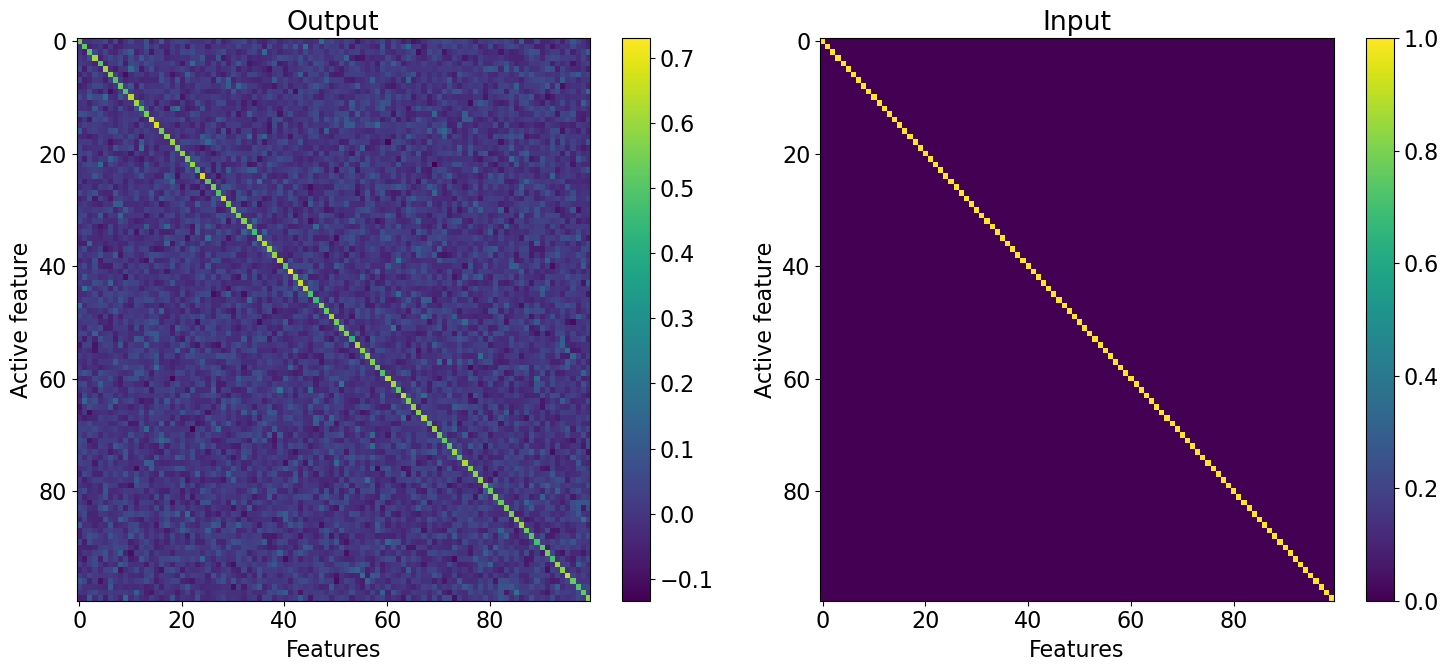

[[ 1.5425513e+00 -6.1169099e-03 -1.0999695e-02 ...  4.3217082e-02
  -9.4572771e-03 -5.9613477e-02]
 [-1.2328728e-02  1.5113294e+00 -5.2396156e-02 ... -3.9706449e-04
  -8.6409133e-03 -5.0138343e-02]
 [-9.7008860e-03 -5.6594916e-02  1.5020871e+00 ... -6.2232707e-03
   3.0628113e-02  1.1574735e-01]
 ...
 [ 4.2376880e-02 -5.7336069e-03 -7.1239439e-03 ...  1.4908669e+00
   4.6300244e-02  5.1330321e-02]
 [-3.2046633e-03 -9.2006382e-03  3.0828631e-02 ...  4.9635287e-02
   1.5177374e+00  1.2905921e-02]
 [-5.9089933e-02 -4.9571976e-02  1.1835194e-01 ...  5.4030575e-02
   9.9174613e-03  1.5756724e+00]]


In [6]:
"""Plot spectrum output plots"""

vals = t.linspace(-1, 1, 100, device=device)  # input values
active_feat_value_idx = 99

n_feat, n_vals = model.cfg.n_feat, len(vals)
# input `X` will be: active_feature_idx X values X full_feature_vector
X = t.zeros(n_feat, n_vals, n_feat, device=device)
feat_idx = t.arange(n_feat, device=device).unsqueeze(1).expand(n_feat, n_vals)
val_idx = t.arange(n_vals, device=device).unsqueeze(0).expand(n_feat, n_vals)
X[feat_idx, val_idx, feat_idx] = vals.unsqueeze(0).expand(n_feat, n_vals)
# reshape for batch input
X = rearrange(X, "active_feat val feat_vec -> (active_feat val) 1 feat_vec")
Y, h, y1, y2 = model.forward(X)
    # reshape for plotting by feature
Y = rearrange(
   Y, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals
)
X = rearrange(X, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals)
print("X.shape = ", X.shape)
print("Y.shape = ", Y.shape)
output= Y[:,active_feat_value_idx,:].cpu().detach().numpy()
input = X[:,active_feat_value_idx,:].cpu().detach().numpy()

fig,axs = plt.subplots(1, 2, figsize=(15, 7))
im0 = axs[0].imshow(output-input, aspect='auto', cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title("Output")
axs[0].set_xlabel("Features")
axs[0].set_ylabel("Active feature")

im1 = axs[1].imshow(input, aspect='auto', cmap='viridis')
fig.colorbar(im1, ax=axs[1])
axs[1].set_title("Input")
axs[1].set_xlabel("Features")
axs[1].set_ylabel("Active feature")
#fig.title(f"{model.cfg.name} trained at featProb = {feat_prob:.2f}:\n output heatmap")
plt.tight_layout()
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_output_heatmap.png" 
plt.savefig(filename, dpi=300)
plt.show()

print(Y[:,active_feat_value_idx,:].cpu().detach().numpy())

In [ ]:


# Choose one-hot input (e.g., 3rd feature active)
index = 1
index = np.argmin(Y[:,99,:].cpu().detach().numpy().diagonal())
index2 = 0 # np.argmin(Y[:,99,:].cpu().detach().numpy().diagonal())
print('index = ', index)
print('index2 = ', index2)
x = t.zeros(1, 1, 100, device=model.device)
#x[0,0,[index, index2]] = 1.0
x[0,0,[index]] = 1.0

# Forward pass
with t.no_grad():
    y, h, y1, y2 = model(x)

fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs = axs.flatten() 

axs[0].bar(range(50), h.squeeze(0).squeeze(0).cpu().detach().numpy())
axs[0].set_xlabel("Hidden Unit")
axs[0].set_ylabel("Activation Value")
axs[0].grid()
axs[0].set_xticks(np.linspace(0, 49, 20, dtype=int)) 

axs[1].bar(range(100), y.squeeze(0).squeeze(0).cpu().detach().numpy())
axs[1].set_xlabel("Final output")
axs[1].set_ylabel("Activation Value")
axs[1].set_xticks(np.linspace(0, 99, 20, dtype=int)) 

axs[2].bar(range(100), y1.squeeze(0).squeeze(0).cpu().detach().numpy())
axs[2].set_xlabel("MLP Output")
axs[2].set_ylabel("Activation Value")
axs[2].set_xticks(np.linspace(0, 99, 20, dtype=int)) 

axs[3].bar(range(100), y2.squeeze(0).squeeze(0).cpu().detach().numpy())
axs[3].set_xlabel("Residual Output")
axs[3].set_ylabel("Activation Value")
axs[3].set_xticks(np.linspace(0, 99, 20, dtype=int)) 

for ax in axs:
    ax.grid(True)
    
plt.tight_layout()
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_feat{index}.png"
#filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_feat{index}_{index2}.png" 
plt.savefig(filename, dpi=300)
plt.show()



Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

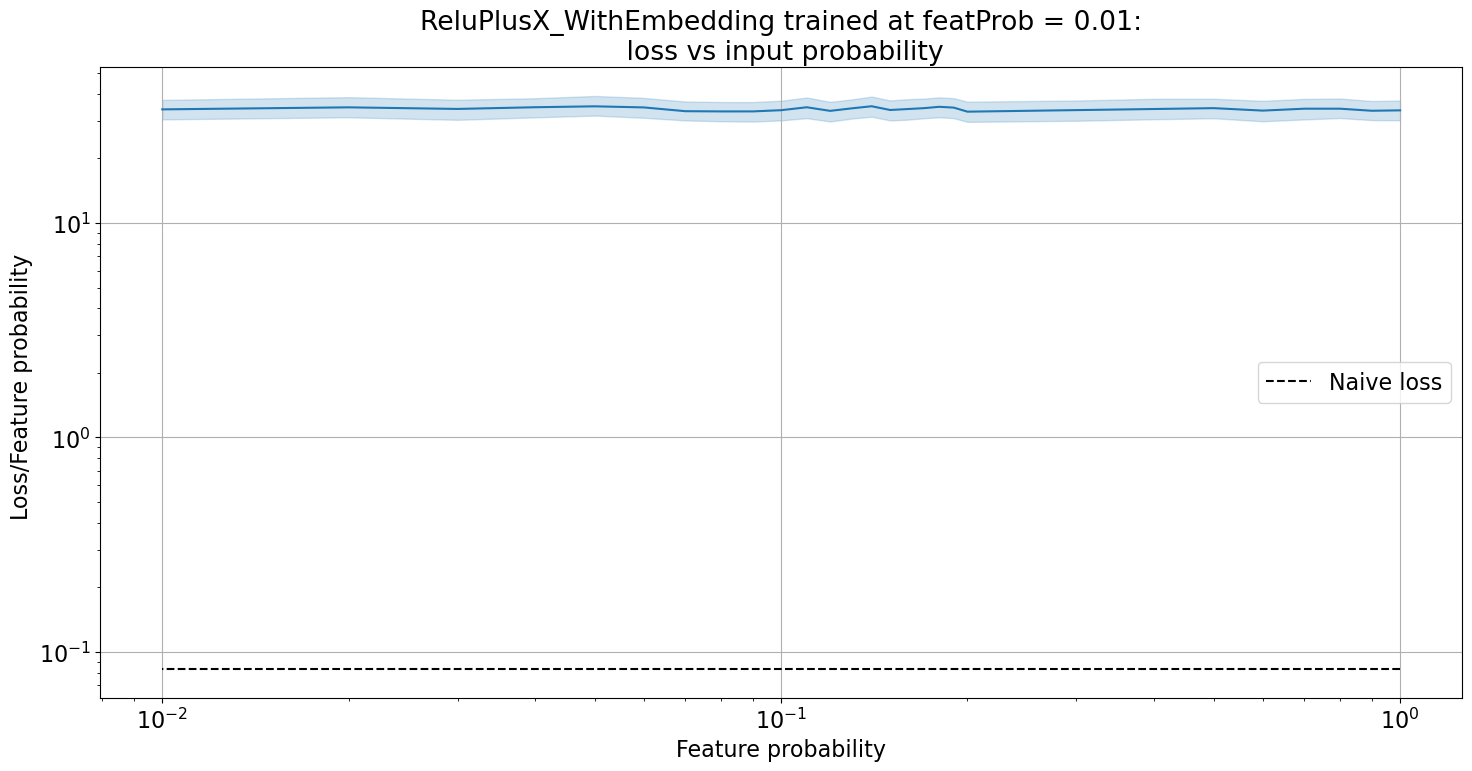

In [8]:
"""Compute and plot the model's performance across sparsities."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1

loss_data = performance_across_sparsities(sparsities, model, noisy_label = True)

"""Plot performance across different input sparsities"""
fig = plot_loss_across_sparsities(loss_data, sparsities, model.cfg.name, feat_sparsity)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_loss_plot.png" 
plt.savefig(filename, dpi=300)
plt.show()

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

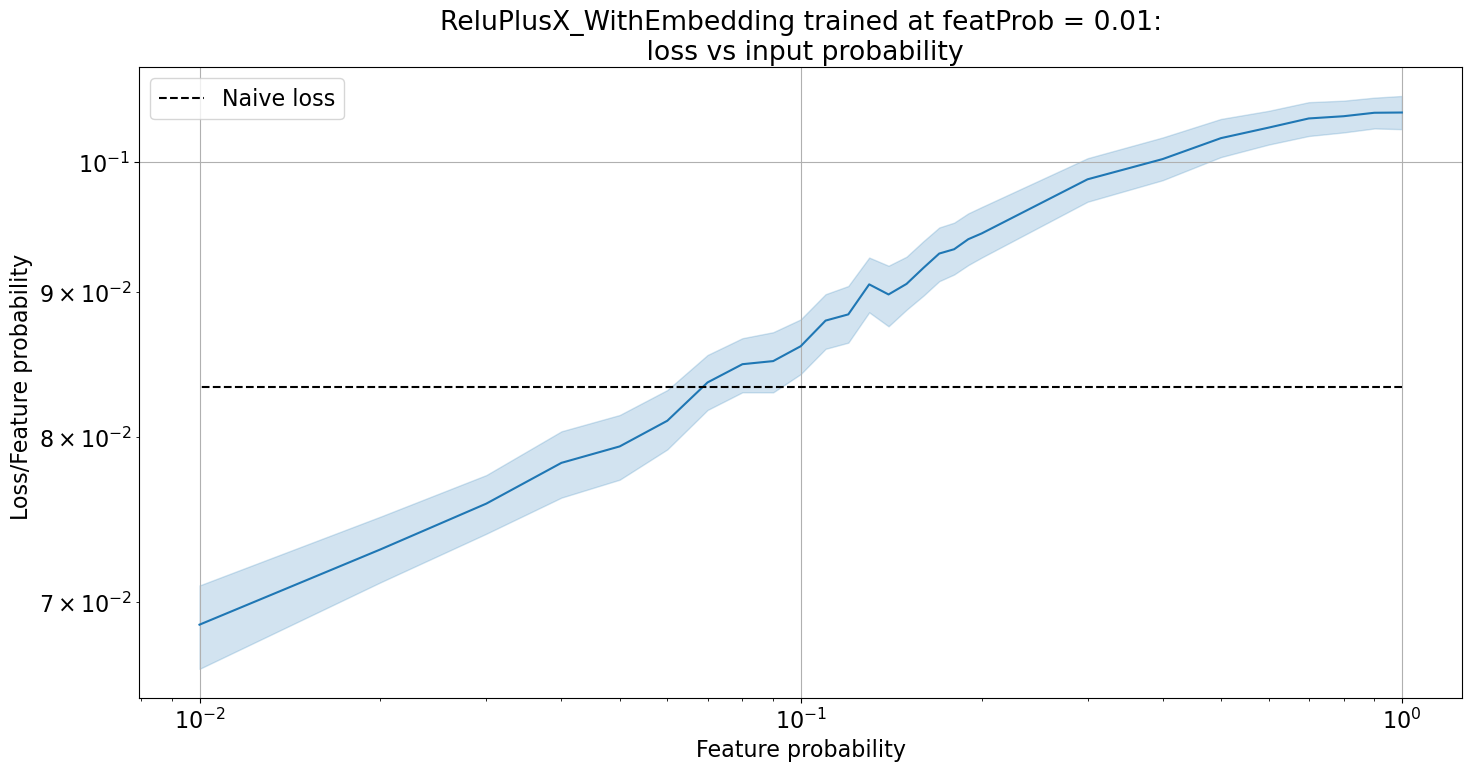

In [7]:
"""Compute and plot the model's performance across sparsities."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1

loss_data = performance_across_sparsities(sparsities, model, noisy_label = False)

"""Plot performance across different input sparsities"""
fig = plot_loss_across_sparsities(loss_data, sparsities, model.cfg.name, feat_sparsity)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_loss_plot.png" 
plt.savefig(filename, dpi=300)
plt.show()

In [ ]:
"""Compute and plot input-output response profile."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(model, vals, device)
print(Y.shape)
fig = plot_input_output_response(Y, vals, model.cfg.name, feat_prob, losses)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_input_output_response.png" 
plt.grid()
plt.savefig(filename, dpi=300)
plt.show()

In [ ]:
plt.figure()
plt.imshow(model.WuT_e.squeeze(0).cpu().detach().numpy(), cmap = "viridis")
plt.show()

plt.figure()
plt.hist(model.WuT_e.squeeze(0).cpu().detach().numpy().flatten(), bins=100)
plt.xlim(-0.1, 0.1)
plt.show()

print(np.unique(model.WuT_e.squeeze(0).cpu().detach().numpy().flatten()))

off_diag_mask = ~t.eye(100, dtype=t.bool, device=model.device)

# 2) Select off-diagonals and move to CPU/NumPy
off_vals = model.WuT_e[off_diag_mask].cpu().detach().numpy()

# 3) Compute and print statistics
print(f"mean   = {off_vals.mean():.4f}")
print(f"median = {np.median(off_vals):.4f}")
print(f"min    = {off_vals.min():.4f}")
print(f"max    = {off_vals.max():.4f}")

W.shape=torch.Size([50, 100])


<function matplotlib.pyplot.show(close=None, block=None)>

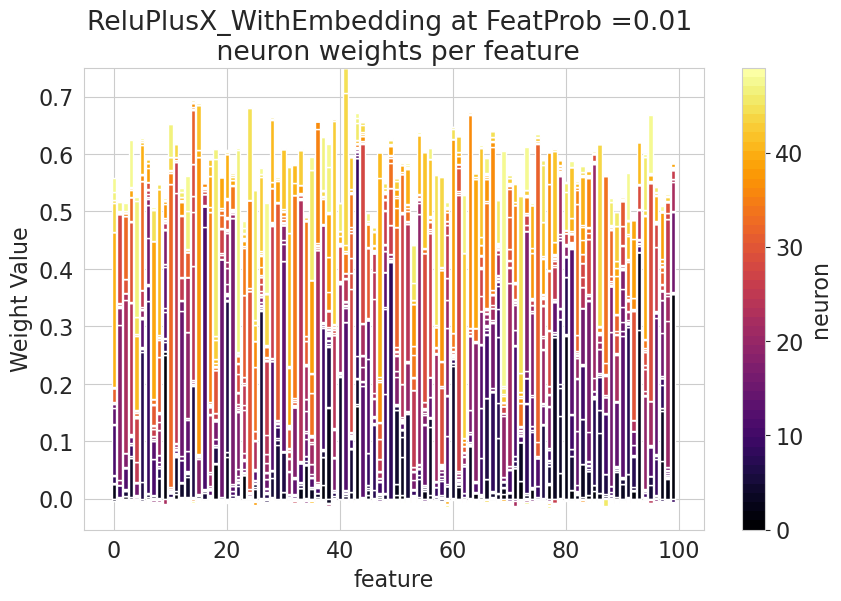

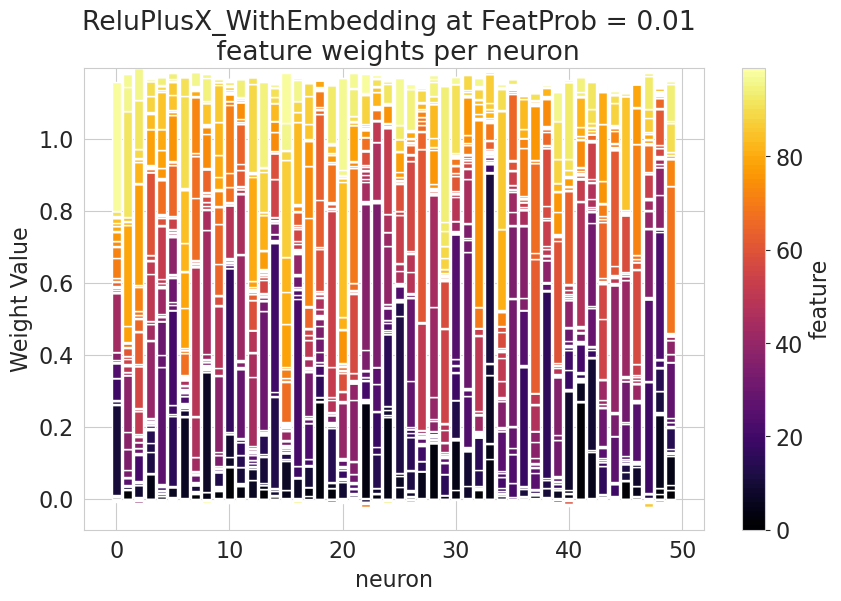

In [10]:
W = einsum(model.W1, model.W2,  "inst neuron feature, inst feature neuron-> neuron feature")
    
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature", model_name=model.cfg.name, feat_prob=feat_prob)
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_weights_per_feature.png" 
plt.savefig(filename, dpi=300)
plt.show

fig = plot_weight_bars(W.T, xax="neuron", model_name=model.cfg.name, feat_prob=feat_prob)
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_weights_per_neuron.png" 
plt.savefig(filename, dpi=300)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

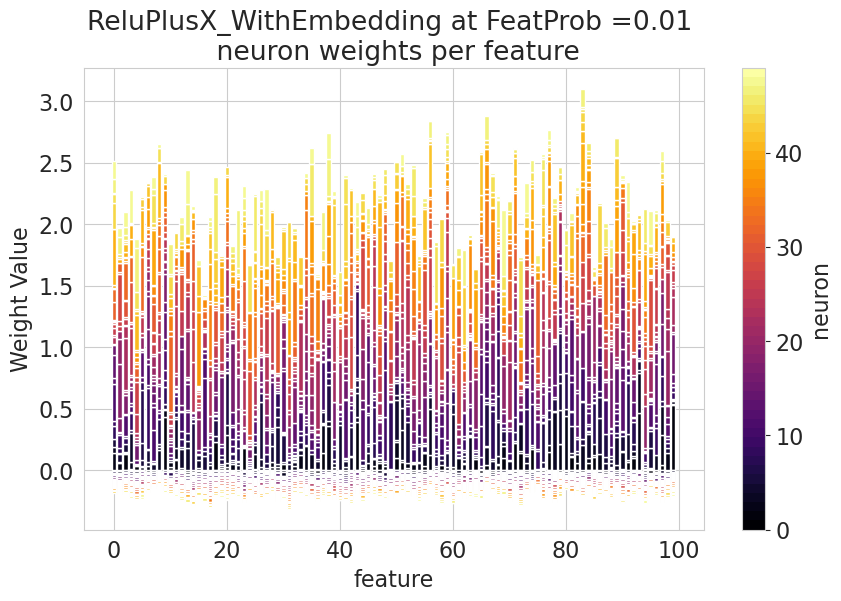

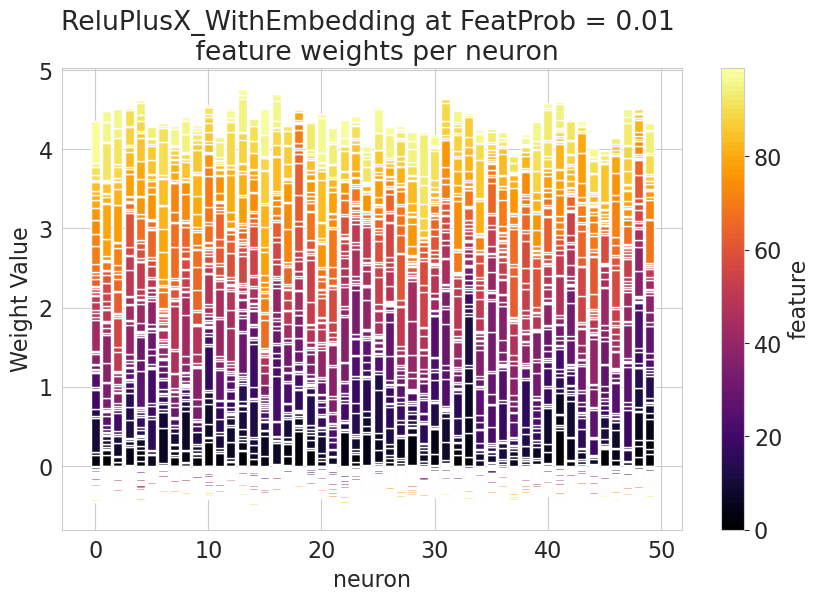

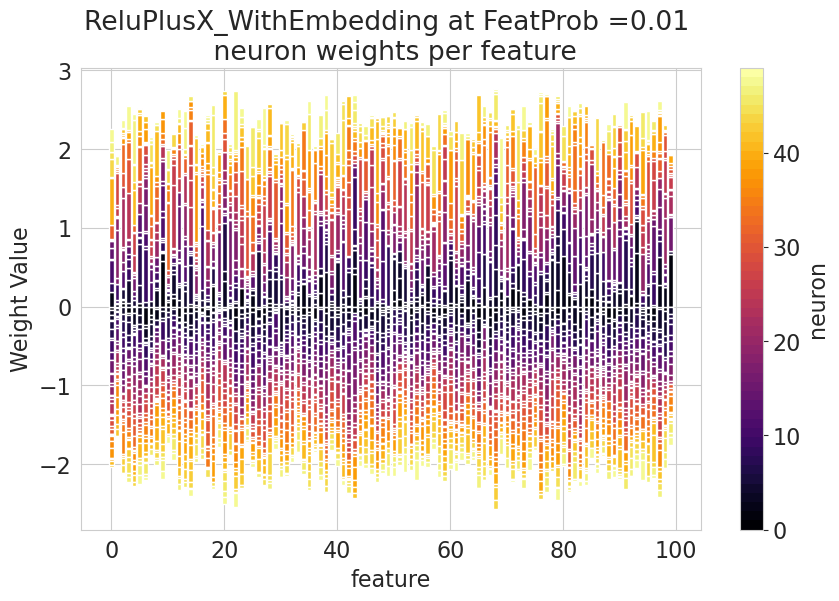

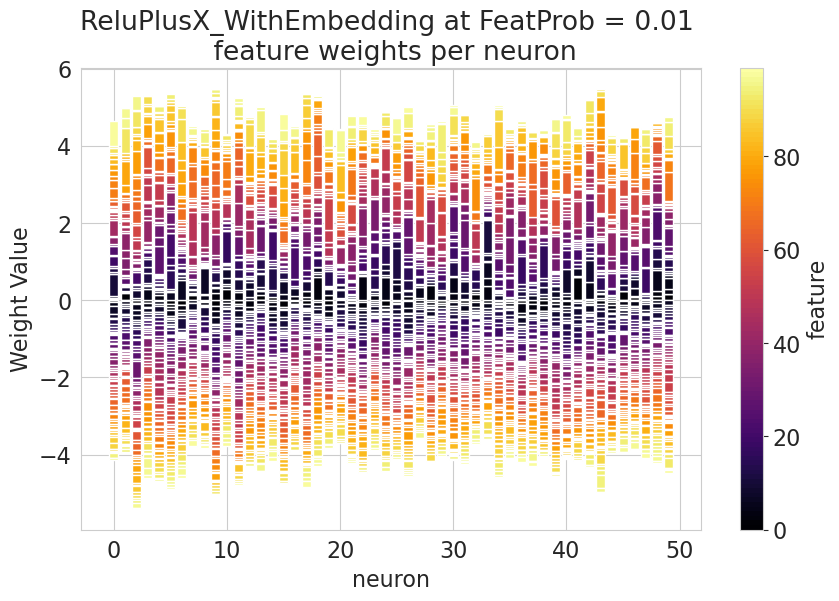

In [14]:
fig = plot_weight_bars(model.W1.squeeze(0), xax="feature", model_name=model.cfg.name, feat_prob=feat_prob)
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_weights_per_feature_Win.png" 
plt.savefig(filename, dpi=300)
plt.show

fig = plot_weight_bars(model.W1.squeeze(0).T, xax="neuron", model_name=model.cfg.name, feat_prob=feat_prob)
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_weights_per_neuron_Win.png" 
plt.savefig(filename, dpi=300)
plt.show

fig = plot_weight_bars(model.W2.squeeze(0).T, xax="feature", model_name=model.cfg.name, feat_prob=feat_prob)
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_weights_per_feature_Wout.png" 
plt.savefig(filename, dpi=300)
plt.show

fig = plot_weight_bars(model.W2.squeeze(0), xax="neuron", model_name=model.cfg.name, feat_prob=feat_prob)
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_weights_per_neuron_Wout.png" 
plt.savefig(filename, dpi=300)
plt.show

# Transplant experiments

In [ ]:
""" Extract weights of the model"""

W_in = model.W1.clone()
W_out = model.W2.clone()

In [ ]:
""" Transplant weights of the Frankenstein model with Pseudo-Relu and transpose-Res into the non-Res model"""

@dataclass
class CisConfig:
    """Config class for single hidden layer CiS model."""
    name: str # name of the model
    n_instances: int  # number of model instances
    n_feat: int  # number of features (elements) in input vector
    n_hidden: int  # number of hidden units in the model
    act_fn: List[Callable] = field(default_factory=lambda: [F.relu, F.relu])  # layer act funcs
    # Bias terms for hidden and output layers. For a given layer, if None, biases are not learned;
    # if scalar, all biases have the same value; if tensor, each bias has the corresponding 
    # tensor element value.
    b1: float | Float[t.Tensor, "inst hid"] | None = None
    b2: float | Float[t.Tensor, "inst hid"] | None = 0.0
    W1_as_W2T: bool = False  # W2 is learned if False, else W2 = W1.T
    We_and_Wu: bool = False  # if True, use fixed, random orthogonal embed and unembed matrices
    We_dim: int = 1000  # if We_and_Wu, this is the dim of the embedding space
    skip_cnx: bool = False  # if True, skip connection from in to out is added
    


    def __post_init__(self):
        """Ensure attribute values are valid."""
        # Handle `b1` tensor validation
        if isinstance(self.b1, t.Tensor):
            expected_shape = (self.n_instances, self.n_hidden)
            if self.b1.shape != expected_shape:
                raise ValueError(f"{self.b1.shape=} does not match {expected_shape=}")
        
        # Handle `b2` tensor validation
        if isinstance(self.b2, t.Tensor):
            expected_shape = (self.n_instances, self.n_hidden)
            if self.b2.shape != expected_shape:
                raise ValueError(f"{self.b2.shape=} does not match {expected_shape=}")



class Cis(nn.Module):
    """A generic computation-in-superposition toy model."""
    # Some attribute type hints
    W1: Float[t.Tensor, "inst hid feat"]
    W2: Float[t.Tensor, "inst feat hid"]
    b1: Float[t.Tensor, "inst hid"]
    b2: Float[t.Tensor, "inst feat"]


    def __init__(self, cfg: CisConfig, device: t.device):
        """Initializes model params."""
        super().__init__()
        self.cfg = cfg
        self.device = device
        n_feat = cfg.n_feat

        # Embed and Unembed Matrices
        if cfg.We_and_Wu:
            rand_unit_mats = [
                F.normalize(t.randn(cfg.We_dim, cfg.n_feat), dim=0, p=2) for _ in range(cfg.n_instances)
            ]
            self.We = t.stack(rand_unit_mats).to(device)
            self.Wu_T = rearrange(self.We, "inst emb feat -> inst feat emb")
            self.Wu_p = t.linalg.pinv(self.We)
            n_feat = cfg.We_dim

            

        # Model Weights
        self.W1 = t.empty(cfg.n_instances, cfg.n_hidden, n_feat)
        self.W1 = nn.Parameter(nn.init.xavier_normal_(self.W1))
        if cfg.W1_as_W2T:
            self.W2 = self.W1.T
        else:
            self.W2 = t.empty(cfg.n_instances, n_feat, cfg.n_hidden)
            self.W2 = nn.Parameter(nn.init.xavier_normal_(self.W2))

        # Model Biases
        if cfg.b1 is None:
            self.b1 = t.zeros(cfg.n_instances, cfg.n_hidden, device=device)
        elif np.isscalar(cfg.b1):
            self.b1 = nn.Parameter(t.full((cfg.n_instances, cfg.n_hidden), cfg.b1))
        else:
            self.b1 = nn.Parameter(cfg.b1)

        if cfg.b2 is None:
            self.b2 = t.zeros(cfg.n_instances, n_feat, device=device)
        elif np.isscalar(cfg.b2):
            self.b2 = nn.Parameter(t.full((cfg.n_instances, n_feat), cfg.b2))
        else:
            self.b2 = nn.Parameter(cfg.b2)
        
        self.to(device)


    def forward(
        self, 
        x: Float[t.Tensor, "batch inst feat"],
    ) -> Float[t.Tensor, "batch inst feat"]:
        """Runs a forward pass through the model."""
        
        e = None
        # Embedding layer
        if self.cfg.We_and_Wu:
            e = einsum(x, self.We, "batch inst feat, inst emb feat -> batch inst emb")
        
        # Hidden layer
        h = einsum(e if e is not None else x, self.W1, "batch inst feat, inst hid feat -> batch inst hid")
        h = self.cfg.act_fn[0](h + self.b1)

        # Output layer
        if self.cfg.We_and_Wu: 
            y1 = einsum(h, self.W2, "batch inst hid, inst emb hid -> batch inst emb")
        else:
            y1 = einsum(h, self.W2, "batch inst hid, inst feat hid -> batch inst feat")
        y1 = self.cfg.act_fn[1](y1 + self.b2)
        
        # Skip connection
        if self.cfg.skip_cnx:
            if self.cfg.We_and_Wu:
                y2 = einsum(x, self.We, "batch inst feat, inst emb feat -> batch inst emb")
            else:
                y1 += x
        
        # Unembedding layer
        if self.cfg.We_and_Wu:
            if self.cfg.skip_cnx: 
                y1 = einsum(y1, self.Wu_p, "batch inst emb, inst feat emb -> batch inst feat")
                y2 = einsum(y2, self.Wu_T, "batch inst emb, inst feat emb -> batch inst feat")
                y = y1 + y2
            else: 
                y = einsum(y1, self.Wu_p, "batch inst emb, inst feat emb -> batch inst feat")
        return y
        
    def gen_batch_reluPlusX (self, batch_sz: int, sparsity: float | Float[t.Tensor, "inst feat"]) -> (
        tuple[Float[t.Tensor, "batch inst feat"], Float[t.Tensor, "batch inst feat"]]
    ):
        """Generates a batch of x, y data."""
        # Randomly generate features vals, and for each, randomly set which samples are non-zero
        x = t.rand(batch_sz, self.cfg.n_instances, self.cfg.n_feat, device=self.device) * 2 - 1  # [-1, 1]
        is_active = (
            t.rand(batch_sz, self.cfg.n_instances, self.cfg.n_feat, device=self.device) < (1 - sparsity)
        )
        x *= is_active
        return x, t.relu(x)

    def loss_fn_reluPlusX(self, y, y_true, i):
        return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

    def train_reluPlusX(
        self,
        batch_sz: int,
        feat_sparsity: float | Float[t.Tensor, "inst feat"],
        feat_importance: float | Float[t.Tensor, "inst feat"],
        n_steps: int,
        lr: float,
        logging_freq: int,
    ) -> List[Float]:
        """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
        losses = []
        
        optimizer = t.optim.AdamW(self.parameters(), lr=lr, weight_decay=0.01)
        
        pbar = tqdm(range(n_steps), desc="Training")
        for step in pbar:
            x, y_true = self.gen_batch_reluPlusX(batch_sz, feat_sparsity)
            y = self.forward(x)
            loss = self.loss_fn_reluPlusX(y, y_true, feat_importance)
            
            # Update the learning rate
            current_lr = lr * np.cos(0.5 * np.pi * step / (n_steps - 1))
            for param_group in optimizer.param_groups:
                param_group["lr"] = current_lr
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Log progress
            if step % logging_freq == 0 or (step + 1 == n_steps):
                losses.append(loss.item())
                pbar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        return losses


In [ ]:
        
layer_act_fns = [t.relu, lambda x: x]

relu_embed_cfg = CisConfig(
    name = "Relu_WithPseudoEmbed",
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=False,
    We_and_Wu=True,
    We_dim=1000,
)


In [ ]:
# Choose a model to train and explore characteristics
"""Select the model configuration"""
model_cfg = relu_embed_cfg

"""Select the feature probability of the training input."""
feat_sparsity = 0.99

In [ ]:
# Train model

"""Training hyperparameters"""
feat_prob = 1 - feat_sparsity
batch_sz = 2048
feat_importance = 1
lr = 3e-3
n_steps = 10000
logging_freq = n_steps // 10

model = Cis(model_cfg, device=device)

losses = model.train_reluPlusX(
        batch_sz,
        feat_sparsity,
        feat_importance,
        n_steps,
        lr, 
        logging_freq, 
)
display(losses)

In [ ]:
"""Plot spectrum output plots"""

vals = t.linspace(-1, 1, 100, device=device)  # input values
active_feat_value_idx = 99

n_feat, n_vals = model.cfg.n_feat, len(vals)
# input `X` will be: active_feature_idx X values X full_feature_vector
X = t.zeros(n_feat, n_vals, n_feat, device=device)
feat_idx = t.arange(n_feat, device=device).unsqueeze(1).expand(n_feat, n_vals)
val_idx = t.arange(n_vals, device=device).unsqueeze(0).expand(n_feat, n_vals)
X[feat_idx, val_idx, feat_idx] = vals.unsqueeze(0).expand(n_feat, n_vals)
# reshape for batch input
X = rearrange(X, "active_feat val feat_vec -> (active_feat val) 1 feat_vec")
Y = model.forward(X)
    # reshape for plotting by feature
Y = rearrange(
   Y, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals
)
X = rearrange(X, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals)
print("X.shape = ", X.shape)
print("Y.shape = ", Y.shape)
output= Y[:,active_feat_value_idx,:].cpu().detach().numpy()
input = X[:,active_feat_value_idx,:].cpu().detach().numpy()

fig,axs = plt.subplots(1, 2, figsize=(15, 7))
im0 = axs[0].imshow(output, aspect='auto', cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title("Output")
axs[0].set_xlabel("Features")
axs[0].set_ylabel("Active feature")

im1 = axs[1].imshow(input, aspect='auto', cmap='viridis')
fig.colorbar(im1, ax=axs[1])
axs[1].set_title("Input")
axs[1].set_xlabel("Features")
axs[1].set_ylabel("Active feature")
#fig.title(f"{model.cfg.name} trained at featProb = {feat_prob:.2f}:\n output heatmap")
plt.tight_layout()
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_output_heatmap.png" 
plt.savefig(filename, dpi=300)
plt.show()

print(Y[:,active_feat_value_idx,:].cpu().detach().numpy())

In [ ]:
"""Compute and plot the model's performance across sparsities."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1

loss_data = performance_across_sparsities(sparsities, model)

"""Plot performance across different input sparsities"""
fig = plot_loss_across_sparsities(loss_data, sparsities, model.cfg.name, feat_sparsity)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_loss_plot.png" 
plt.savefig(filename, dpi=300)
plt.show()

In [ ]:
"""Compute and plot input-output response profile."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(model, vals, device)
print(Y.shape)
fig = plot_input_output_response(Y, vals, model.cfg.name, feat_prob, losses)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_input_output_response.png" 
plt.savefig(filename, dpi=300)
plt.show()

In [ ]:
""" Transplant the weights from the res to the non-res model"""

print('W1 = ', model.W1)
print('W2 = ', model.W2)
#with t.no_grad():
model.W1.data = W_in #nn.Parameter(W_in) # model.W1.copy_(W_in) #
model.W2.data = W_out #nn.Parameter(W_out) # model.W2.copy_(W_out) #
print('W1 = ', model.W1)
print('W2 = ', model.W2)


In [ ]:
"""Plot spectrum output plots"""

vals = t.linspace(-1, 1, 100, device=device)  # input values
active_feat_value_idx = 99

n_feat, n_vals = model.cfg.n_feat, len(vals)
# input `X` will be: active_feature_idx X values X full_feature_vector
X = t.zeros(n_feat, n_vals, n_feat, device=device)
feat_idx = t.arange(n_feat, device=device).unsqueeze(1).expand(n_feat, n_vals)
val_idx = t.arange(n_vals, device=device).unsqueeze(0).expand(n_feat, n_vals)
X[feat_idx, val_idx, feat_idx] = vals.unsqueeze(0).expand(n_feat, n_vals)
# reshape for batch input
X = rearrange(X, "active_feat val feat_vec -> (active_feat val) 1 feat_vec")
Y = model.forward(X)
    # reshape for plotting by feature
Y = rearrange(
   Y, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals
)
X = rearrange(X, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals)
print("X.shape = ", X.shape)
print("Y.shape = ", Y.shape)
output= Y[:,active_feat_value_idx,:].cpu().detach().numpy()
input = X[:,active_feat_value_idx,:].cpu().detach().numpy()

fig,axs = plt.subplots(1, 2, figsize=(15, 7))
im0 = axs[0].imshow(output, aspect='auto', cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title("Output")
axs[0].set_xlabel("Features")
axs[0].set_ylabel("Active feature")

im1 = axs[1].imshow(input, aspect='auto', cmap='viridis')
fig.colorbar(im1, ax=axs[1])
axs[1].set_title("Input")
axs[1].set_xlabel("Features")
axs[1].set_ylabel("Active feature")
#fig.title(f"{model.cfg.name} trained at featProb = {feat_prob:.2f}:\n output heatmap")
plt.tight_layout()
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_output_heatmap.png" 
plt.savefig(filename, dpi=300)
plt.show()

print(Y[:,active_feat_value_idx,:].cpu().detach().numpy())

In [ ]:
"""Compute and plot the model's performance across sparsities."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1

loss_data = performance_across_sparsities(sparsities, model)

"""Plot performance across different input sparsities"""
fig = plot_loss_across_sparsities(loss_data, sparsities, model.cfg.name, feat_sparsity)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_loss_plot.png" 
plt.savefig(filename, dpi=300)
plt.show()

In [ ]:
"""Compute and plot input-output response profile."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(model, vals, device)
print(Y.shape)
fig = plot_input_output_response(Y, vals, model.cfg.name, feat_prob, losses)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_input_output_response.png" 
plt.savefig(filename, dpi=300)
plt.show()

In [ ]:


"""Frankenstein mode: ReLU model where MLP output is unembedded by the pseudoinverse of embedding matrix 
but additional noise is added to it. The amount of noise can be controlled. 
"""

from dataclasses import dataclass, field
from typing import Callable, List
from tqdm.notebook import tqdm

import numpy as np
import torch as t

from einops import einsum, rearrange, reduce
from jaxtyping import Float
from torch import nn
from torch.nn import functional as F


@dataclass
class CisConfig:
    """Config class for single hidden layer CiS model."""
    name: str # name of the model
    n_instances: int  # number of model instances
    n_feat: int  # number of features (elements) in input vector
    n_hidden: int  # number of hidden units in the model
    act_fn: List[Callable] = field(default_factory=lambda: [F.relu, F.relu])  # layer act funcs
    # Bias terms for hidden and output layers. For a given layer, if None, biases are not learned;
    # if scalar, all biases have the same value; if tensor, each bias has the corresponding 
    # tensor element value.
    b1: float | Float[t.Tensor, "inst hid"] | None = None
    b2: float | Float[t.Tensor, "inst hid"] | None = 0.0
    W1_as_W2T: bool = False  # W2 is learned if False, else W2 = W1.T
    We_and_Wu: bool = False  # if True, use fixed, random orthogonal embed and unembed matrices
    We_dim: int = 1000  # if We_and_Wu, this is the dim of the embedding space
    skip_cnx: bool = False  # if True, skip connection from in to out is added
    


    def __post_init__(self):
        """Ensure attribute values are valid."""
        # Handle `b1` tensor validation
        if isinstance(self.b1, t.Tensor):
            expected_shape = (self.n_instances, self.n_hidden)
            if self.b1.shape != expected_shape:
                raise ValueError(f"{self.b1.shape=} does not match {expected_shape=}")
        
        # Handle `b2` tensor validation
        if isinstance(self.b2, t.Tensor):
            expected_shape = (self.n_instances, self.n_hidden)
            if self.b2.shape != expected_shape:
                raise ValueError(f"{self.b2.shape=} does not match {expected_shape=}")



class Cis(nn.Module):
    """A generic computation-in-superposition toy model."""
    # Some attribute type hints
    W1: Float[t.Tensor, "inst hid feat"]
    W2: Float[t.Tensor, "inst feat hid"]
    b1: Float[t.Tensor, "inst hid"]
    b2: Float[t.Tensor, "inst feat"]


    def __init__(self, cfg: CisConfig, device: t.device):
        """Initializes model params."""
        super().__init__()
        self.cfg = cfg
        self.device = device
        n_feat = cfg.n_feat

        # Embed and Unembed Matrices
        if cfg.We_and_Wu:
            rand_unit_mats = [
                F.normalize(t.randn(cfg.We_dim, cfg.n_feat), dim=0, p=2) for _ in range(cfg.n_instances)
            ]
            self.We = t.stack(rand_unit_mats).to(device)
            self.Wu_T = rearrange(self.We, "inst emb feat -> inst feat emb")
            self.Wu_p = t.linalg.pinv(self.We)
            n_feat = cfg.We_dim

            

        # Model Weights
        self.W1 = t.empty(cfg.n_instances, cfg.n_hidden, n_feat)
        self.W1 = nn.Parameter(nn.init.xavier_normal_(self.W1))
        if cfg.W1_as_W2T:
            self.W2 = self.W1.T
        else:
            self.W2 = t.empty(cfg.n_instances, n_feat, cfg.n_hidden)
            self.W2 = nn.Parameter(nn.init.xavier_normal_(self.W2))

        # Model Biases
        if cfg.b1 is None:
            self.b1 = t.zeros(cfg.n_instances, cfg.n_hidden, device=device)
        elif np.isscalar(cfg.b1):
            self.b1 = nn.Parameter(t.full((cfg.n_instances, cfg.n_hidden), cfg.b1))
        else:
            self.b1 = nn.Parameter(cfg.b1)

        if cfg.b2 is None:
            self.b2 = t.zeros(cfg.n_instances, n_feat, device=device)
        elif np.isscalar(cfg.b2):
            self.b2 = nn.Parameter(t.full((cfg.n_instances, n_feat), cfg.b2))
        else:
            self.b2 = nn.Parameter(cfg.b2)
        
        self.to(device)


    def forward(
        self, 
        x: Float[t.Tensor, "batch inst feat"],
    ) -> Float[t.Tensor, "batch inst feat"]:
        """Runs a forward pass through the model."""
        
        e = None
        # Embedding layer
        if self.cfg.We_and_Wu:
            e = einsum(x, self.We, "batch inst feat, inst emb feat -> batch inst emb")
        
        # Hidden layer
        h = einsum(e if e is not None else x, self.W1, "batch inst feat, inst hid feat -> batch inst hid")
        h = self.cfg.act_fn[0](h + self.b1)

        # Output layer
        if self.cfg.We_and_Wu: 
            y1 = einsum(h, self.W2, "batch inst hid, inst emb hid -> batch inst emb")
        else:
            y = einsum(h, self.W2, "batch inst hid, inst feat hid -> batch inst feat")
        y1 = self.cfg.act_fn[1](y1 + self.b2)
        
        # Skip connection
        if self.cfg.skip_cnx:
            if self.cfg.We_and_Wu:
                y2 = einsum(x, self.We, "batch inst feat, inst emb feat -> batch inst emb")
            else:
                y += x
        
        # Unembedding layer
        if self.cfg.We_and_Wu:
            y = einsum(y1, self.Wu_p, "batch inst emb, inst feat emb -> batch inst feat")
            #y2 = einsum(y2, self.Wu_T, "batch inst emb, inst feat emb -> batch inst feat")
            #y = y1 + y2

            # add noise to y
            mean = 0.1 * x
            std = 0.02
            noise = t.normal(mean=0.0, std=std, size=y.shape, device=self.device)
            noise += mean
            y = y + noise
        return y
        
    def gen_batch_reluPlusX (self, batch_sz: int, sparsity: float | Float[t.Tensor, "inst feat"]) -> (
        tuple[Float[t.Tensor, "batch inst feat"], Float[t.Tensor, "batch inst feat"]]
    ):
        """Generates a batch of x, y data."""
        # Randomly generate features vals, and for each, randomly set which samples are non-zero
        x = t.rand(batch_sz, self.cfg.n_instances, self.cfg.n_feat, device=self.device) * 2 - 1  # [-1, 1]
        is_active = (
            t.rand(batch_sz, self.cfg.n_instances, self.cfg.n_feat, device=self.device) < (1 - sparsity)
        )
        x *= is_active
        
        return x, t.relu(x) #+ x

    def loss_fn_reluPlusX(self, y, y_true, i):
        return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

    def train_reluPlusX(
        self,
        batch_sz: int,
        feat_sparsity: float | Float[t.Tensor, "inst feat"],
        feat_importance: float | Float[t.Tensor, "inst feat"],
        n_steps: int,
        lr: float,
        logging_freq: int,
    ) -> List[Float]:
        """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
        losses = []
        
        optimizer = t.optim.AdamW(self.parameters(), lr=lr, weight_decay=0.01)
        
        pbar = tqdm(range(n_steps), desc="Training")
        for step in pbar:
            x, y_true = self.gen_batch_reluPlusX(batch_sz, feat_sparsity)
            y = self.forward(x)
            loss = self.loss_fn_reluPlusX(y, y_true, feat_importance)
            
            # Update the learning rate
            current_lr = lr * np.cos(0.5 * np.pi * step / (n_steps - 1))
            for param_group in optimizer.param_groups:
                param_group["lr"] = current_lr
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Log progress
            if step % logging_freq == 0 or (step + 1 == n_steps):
                losses.append(loss.item())
                pbar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        return losses
# Note:
# Feature sparsity should be used in a function that generates batches.
# Feature importance should be used in a loss function.
# Both of these should be defined outside of this class, and called in a training loop.


In [ ]:
"""ReLU + x model with Random embedding"""
layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg = CisConfig(
    name = "ReluPlusX_WithEmbedding",
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=False,
    We_and_Wu=True,
    We_dim=1000,
)

In [ ]:
# Choose a model to train and explore characteristics
"""Select the model configuration"""
model_cfg = reluPlusX_res_embed_cfg

"""Select the feature probability of the training input."""
feat_sparsity = 0.99

In [ ]:
# Train model

"""Training hyperparameters"""
feat_prob = 1 - feat_sparsity
batch_sz = 2048
feat_importance = 1
lr = 3e-3
n_steps = 10000
logging_freq = n_steps // 10

model = Cis(model_cfg, device=device)

losses = model.train_reluPlusX(
        batch_sz,
        feat_sparsity,
        feat_importance,
        n_steps,
        lr, 
        logging_freq, 
)
display(losses)

In [ ]:
"""Plot spectrum output plots"""

vals = t.linspace(-1, 1, 100, device=device)  # input values
active_feat_value_idx = 99

n_feat, n_vals = model.cfg.n_feat, len(vals)
# input `X` will be: active_feature_idx X values X full_feature_vector
X = t.zeros(n_feat, n_vals, n_feat, device=device)
feat_idx = t.arange(n_feat, device=device).unsqueeze(1).expand(n_feat, n_vals)
val_idx = t.arange(n_vals, device=device).unsqueeze(0).expand(n_feat, n_vals)
X[feat_idx, val_idx, feat_idx] = vals.unsqueeze(0).expand(n_feat, n_vals)
# reshape for batch input
X = rearrange(X, "active_feat val feat_vec -> (active_feat val) 1 feat_vec")
Y = model.forward(X)
    # reshape for plotting by feature
Y = rearrange(
   Y, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals
)
X = rearrange(X, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals)
print("X.shape = ", X.shape)
print("Y.shape = ", Y.shape)
output= Y[:,active_feat_value_idx,:].cpu().detach().numpy()
input = X[:,active_feat_value_idx,:].cpu().detach().numpy()

fig,axs = plt.subplots(1, 2, figsize=(15, 7))
im0 = axs[0].imshow(output-input, aspect='auto', cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title("Output")
axs[0].set_xlabel("Features")
axs[0].set_ylabel("Active feature")

im1 = axs[1].imshow(input, aspect='auto', cmap='viridis')
fig.colorbar(im1, ax=axs[1])
axs[1].set_title("Input")
axs[1].set_xlabel("Features")
axs[1].set_ylabel("Active feature")
#fig.title(f"{model.cfg.name} trained at featProb = {feat_prob:.2f}:\n output heatmap")
plt.tight_layout()
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_output_heatmap.png" 
plt.savefig(filename, dpi=300)
plt.show()

print(Y[:,active_feat_value_idx,:].cpu().detach().numpy())

In [ ]:
"""Compute and plot the model's performance across sparsities."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1

loss_data = performance_across_sparsities(sparsities, model)

"""Plot performance across different input sparsities"""
fig = plot_loss_across_sparsities(loss_data, sparsities, model.cfg.name, feat_sparsity)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_loss_plot.png" 
plt.savefig(filename, dpi=300)
plt.show()

In [ ]:
"""Compute and plot input-output response profile."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(model, vals, device)
print(Y.shape)
fig = plot_input_output_response(Y, vals, model.cfg.name, feat_prob, losses)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_input_output_response.png" 
plt.savefig(filename, dpi=300)
plt.show()